# Teaching a Robot to Move

First, we have a neural network watch a teacher. The robot starts at the end of a hallway, and approaches a target location 1 meter from the end of the hall.

In [8]:
from conx import *
from jyro.simulator import *
import math

In [9]:
def make_world(physics):
    physics.addBox(0, 0, 8, 2, fill="backgroundgreen", wallcolor="gray")
    #physics.addBox(0, 0, 2, 2, fill="backgroundgreen", wallcolor="gray")
    
def make_robot():
    robot = Pioneer("Pioneer", 7.5, 1, math.pi/2) #paremeters are x, y, heading (in radians)
    robot.addDevice(PioneerFrontSonars(4))
    robot.addDevice(Camera())
    return robot

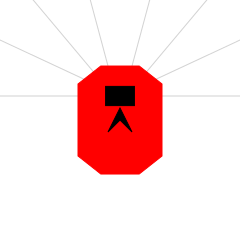

In [10]:
robot = make_robot()
robot

In [11]:
robot.history = []
data = []
mode = "go"

def brain(robot):
    global mode
    if robot.getPose() == (1, 2, 0):
        print("Reset!")
    sonars = robot["sonar"].getData()
    dist = min(sonars[3:5])
    if dist <= 1.0:
        power = 0
    else:
        power = max((dist - 1)/4.0, 0.1)
    if mode == "go":
        robot.move(power, 0)
        robot.history.append(robot.getPose())
        data.append([[v/6.0 for v in sonars[3:5]], [power]])
        if dist < 1.0: 
            mode = "stop"
            print("Done!")

robot.brain = brain

In [12]:
sim = VSimulator(robot, make_world, size=(700, 180))

VBox(children=(VBox(children=(HBox(children=(Checkbox(value=True, description='Update GUI'), Checkbox(value=False, description='Trace Path'), Text(value='0.0 seconds', description='Time:'))), HBox(children=(VBox(children=(HBox(children=(FloatSlider(value=0.0, layout=Layout(height='180px', padding='0px 0px 0px 0px', width='15px'), orientation='vertical', readout=False), HTML(value='<svg baseProfile="full" height="180" version="1.1" width="700" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><rect fill="#eef3dd" height="175.0" stroke="#bebebe" stroke-width="1" width="700.0" x="0.0" y="0.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="647.5" x2="647.5" y1="102.8125" y2="175.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="641.375" x2="606.6933688022468" y1="100.62499999999999" y2="175.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="638.75" x2="545.9421876139614" y1="97.12499999999999" y2="175.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="636.5625" x2="326.3357755873128" y1="91.87499999999999" y2="175.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="636.5625" x2="326.3357755873128" y1="83.125" y2="0.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="638.75" x2="545.9421876139614" y1="77.87499999999999" y2="0.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="641.375" x2="606.6933688022468" y1="74.37500000000001" y2="0.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="647.5" x2="647.5" y1="72.1875" y2="0.0" /><line fill="#800080" stroke="#a020f0" stroke-width="1" x1="656.25" x2="605.7318512251488" y1="87.5" y2="175.0" /><line fill="#800080" stroke="#a020f0" stroke-width="1" x1="656.25" x2="605.7318512251488" y1="87.5" y2="0.0" /><polygon fill="red" points="636.5625,94.5 643.125,102.8125 669.375,102.8125 675.9375,94.5 675.9375,80.5 669.375,72.1875 643.125,72.1875 636.5625,80.5" stroke="red" stroke-width="1" /><polygon points="-4.375,-4.375 0,0 4.375,-4.375 0,4.375" stroke="black" stroke-width="1" transform="translate(656.25,87.5) rotate(90.0)" /><polygon fill="black" points="644.0,82.25 651.0,82.25 651.0,92.75 644.0,92.75" stroke="black" stroke-width="1" /></svg>'))), FloatSlider(value=0.0, layout=Layout(height='15px', padding='0px 0px 0px 10px', width='720px'), readout=False)), layout=Layout(height='240px')), VBox(children=(HTML(value='<img style="image-rendering: pixelated;" src="data:image/gif;base64,R0lGODdhPAAoAIcAAO7z3a3Y5qioqKenp6ampqWlpaSkpKOjo6KioqGhoaCgoJ6enp2dnZubm5mZmZeXl5SUlJGRkY6OjomJiYSEhH5+fnV1dWpqalxcXEZGRi8vLy4uLgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACwAAAAAPAAoAEAI/wADCBxIsKDBgwgTKlzIsKHDhwIGDCBQoICBAwgSKFjAoIGDBxAiSJhAoYKFAChTqlRpoQKFCRIiQHjgoAGDBQoSIDhgoEABAgMGCBAwYACBAgUMHECQQMECBg0cPIAQQcIEChUAaN3KtSuAChQmSIgA4YGDBgwWKEiA4ICBAgUIDBggAIDdu3jz6t3Lt6/fvAECCx5MuLDhw4gTExYwYACBAgUCSJ5MubLly5gzTy5QgMCAAQIEDBhAoEABAwcQJFCwgEEDBw8gRJAwgUIFCxcwZNiwQYNvDRs2ZMBwwUIFChMkRIDwwEEDBgsUJEBwwECBAgQGDBAAoLv37+DDi/8fT768+fPo06sPwL69+/fw48ufT7++/fv48+vfz3++AIADBhAoUMDAAQQJFC

In [12]:
sim.canvas._canvas.size = (480, 480)
sim.canvas._canvas.viewbox(0, 0, 480, 480)

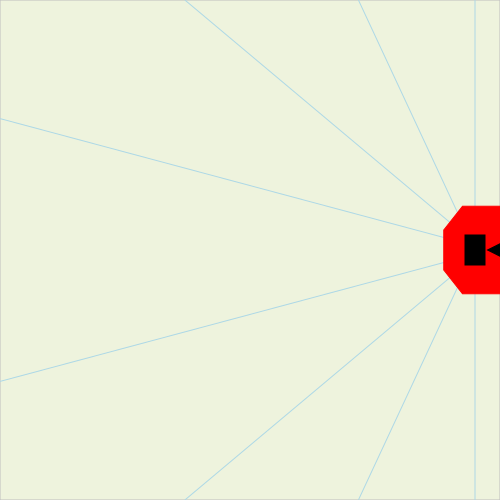

In [7]:
sim.canvas._canvas

In [42]:
sim.widgets["play"]._playing = False

In [33]:
sim.widgets["play"].show_repeat = False

In [31]:
sim.widgets["play"]._playing = True

In [70]:
len(data)

131

In [74]:
net = Network("Stop When Close")
net.add(Layer("input", 2))
net.add(Layer("hidden", 5, activation="sigmoid"))
net.add(Layer("output", 1, activation = "tanh"))
net.connect()
net.compile(loss="mse", optimizer="adam")
net.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2)                 0         
_________________________________________________________________
hidden (Dense)               (None, 5)                 15        
_________________________________________________________________
output (Dense)               (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [75]:
net.dataset.load(data)
net.dataset.shuffle()
net.dataset.summary()

Input Summary:
   count  : 131 (131 for training, 0 for testing)
   shape  : [(2,)]
   range  : (0.16572869, 0.611753)
Target Summary:
   count  : 131 (131 for training, 0 for testing)
   shape  : [(1,)]
   range  : (0.0, 0.66762954)


In [91]:
net.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, options=('Test', 'Train'), rows=1, value='Train'), FloatSlider(value=1.0, continuous_update=False, description='Zoom', max=3.0, min=0.5), IntText(value=150, description='Horizontal space between banks:', style=DescriptionStyle(description_width='initial')), IntText(value=30, description='Vertical space between layers:', style=DescriptionStyle(description_width='initial')), HBox(children=(Checkbox(value=False, description='Show Targets', style=DescriptionStyle(description_width='initial')), Checkbox(value=False, description='Errors', style=DescriptionStyle(description_width='initial')))), Select(description='Features:', options=('',), rows=1, value=''), IntText(value=3, description='Feature columns:', style=DescriptionStyle(description_width='initial')), FloatText(value=2.0, description='Feature scale:', style=DescriptionStyle(description_width='initial'))), layout=Layout(width='100%')), VBox(children=(Select(description='Layer:', index=2, options=('input', 'hidden', 'output'), rows=1, value='output'), Checkbox(value=True, description='Visible'), Select(description='Colormap:', options=('', 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Vega10', 'Vega10_r', 'Vega20', 'Vega20_r', 'Vega20b', 'Vega20b_r', 'Vega20c', 'Vega20c_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spectral', 'spectral_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'viridis', 'viridis_r', 'winter', 'winter_r'), rows=1, value=''), HTML(value='<img src="data:image/gif;base64,R0lGODdhLAEZAIcAAPEBAY8AAM8AAAEB8q8AAAAAbwAAsAAAkAAA0PTo8vr3+wAAV0dH/7e3//9WVv/W1hYW/zQ0/2dn/4aG/6Sk/9nZ//8XF/82Nv9oaP+Xl/+1tSQk/1lZ/3h4/5SU/8nJ//8mJv9ERP95ef+Hh/+mpv/ExH8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

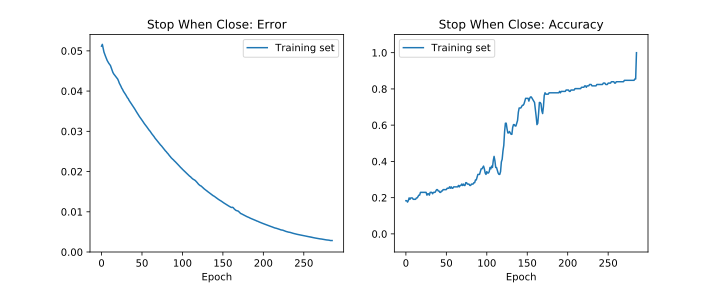

       |  Training |  Training 
Epochs |     Error |  Accuracy 
------ | --------- | --------- 
#  285 |   0.00285 |   1.00000 


In [76]:
if net.saved():
    net.load()
    net.plot_loss_acc()
else:
    net.train(1000, accuracy=1.0, tolerance=0.1, plot=True)
    net.save()

In [ ]:
train = ["Training Data", [pair[1][0] for pair in data]]

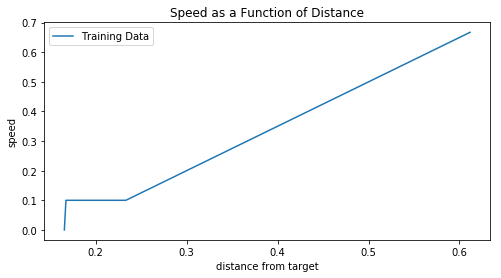

In [88]:
plot(train, 
     title="Speed as a Function of Distance",
     xlabel="distance from target",
     ylabel="speed",
     xs=[pair[0][0] for pair in data])

In [89]:
test = ["Network", [net.propagate(pair[0], visualize=False)[0] for pair in data]]

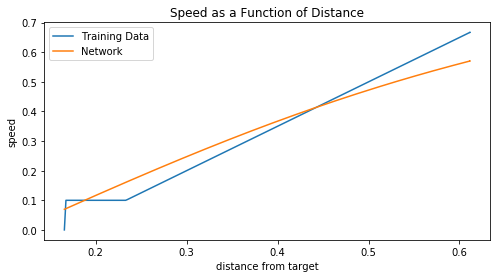

In [90]:
plot([train, test], 
     title="Speed as a Function of Distance",
     xlabel="distance from target",
     ylabel="speed",
     xs=[pair[0][0] for pair in data])

# Network-Controlled Robot

In [98]:
outputs = []

def net_brain(robot):
    sonars = robot["sonar"].getData()
    inputs = [v/6.0 for v in sonars[3:5]]
    output = net.propagate(inputs, visualize=False)[0]
    robot.move(output, 0)
    outputs.append([inputs[0], output])
        
robot.brain = net_brain

In [96]:
sim.widget

VBox(children=(VBox(children=(HBox(children=(Checkbox(value=True, description='Update GUI'), Checkbox(value=False, description='Trace Path'), Text(value='24.60 seconds', description='Time:'))), HBox(children=(VBox(children=(HBox(children=(FloatSlider(value=88.76085589975128, layout=Layout(height='248px', padding='0px 0px 0px 0px', width='10px'), orientation='vertical', readout=False), HTML(value='<svg baseProfile="full" height="240" version="1.1" width="240" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><rect fill="#eef3dd" height="240.0" stroke="#bebebe" stroke-width="1" width="80.0" x="0.0" y="0.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="33.0" x2="0.0" y1="22.973945840596954" y2="22.973944000000017" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="34.0" x2="0.0" y1="20.173945840596943" y2="4.319483999999996" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="35.6" x2="19.67897055230208" y1="18.973945840596933" y2="0.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="38.0" x2="33.183896456712134" y1="17.973945840596954" y2="0.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="42.0" x2="46.81610354328788" y1="17.973945840596954" y2="0.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="44.400000000000006" x2="60.3210294476979" y1="18.973945840596933" y2="0.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="46.0" x2="80.0" y1="20.173945840596943" y2="4.319484000000031" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="47.0" x2="80.0" y1="22.973945840596954" y2="22.973944000000017" /><line fill="#800080" stroke="#a020f0" stroke-width="1" x1="40.0" x2="0.0" y1="26.97394584059694" y2="3.8799320000000037" /><line fill="#800080" stroke="#a020f0" stroke-width="1" x1="40.0" x2="80.0" y1="26.97394584059694" y2="3.8799320000000037" /><polygon fill="red" points="36.800000000000004,17.973945840596954 33.0,20.973945840596926 33.0,32.973945840596954 36.800000000000004,35.973945840596926 43.2,35.973945840596926 47.0,32.973945840596954 47.0,20.973945840596926 43.2,17.973945840596954" stroke="red" stroke-width="1" /><polygon points="-2.0,-2.0 0,0 2.0,-2.0 0,2.0" stroke="black" stroke-width="1" transform="translate(40.0,26.97394584059694) rotate(180.0)" /><polygon fill="black" points="42.400000000000006,21.373945840596953 42.400000000000006,24.573945840596956 37.599999999999994,24.573945840596956 37.599999999999994,21.373945840596953" stroke="black" stroke-width="1" /></svg>'))), FloatSlider(value=50.0, layout=Layout(height='30px', padding='0px 0px 0px 10px', width='260px'), readout=False))), VBox(children=(HTML(value='<img style="image-rendering: pixelated;" src="data:image/gif;base64,R0lGODdhPAAoAIcAAO7z3a3Y5rGxsbCwsK+vr66urq2traysrKurq6qqqqmpqaioqKenpwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACwAAAAAPAAoAEAI/wADCBxIsKDBgwgTKlzIsKHDhwsYMFigIEECBAcOGDBQoCOBjwNCihwgoKTJkwNSqhxAoGWBlwYMHDiAIEECBQsYMFiwgAGDBQoSJEBw4IABAwWSElg6oKnTAQKiSp06oKrVAQSyFth

In [99]:
trained_range = ["Net in Trained Range", outputs[:]]
outputs = []

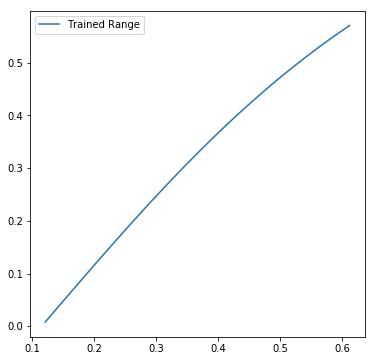

In [100]:
scatter(trained_range)

In [101]:
untrained_range = ["Net out of Trained Range", outputs[:]]

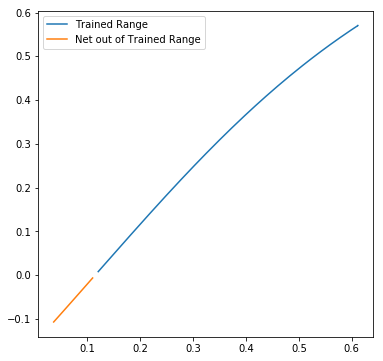

In [102]:
scatter([trained_range, untrained_range])